# Evaluating $\arg\max_{p \in \cal{C}} R(p) := \frac{p}{\mathbb{E}[A \vert p]}$ via IPA
# Simultaneously learning $\lambda, (\theta_1, \theta_2)$

In [1]:
import math

import numpy as np
import pandas as pd

from scipy.optimize import fsolve, minimize, Bounds, LinearConstraint
from scipy.integrate import quad
from scipy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape

import matplotlib.pyplot as plt

from collections import deque

import time

In [2]:
def generate_service_times(x, n):
    # Exponentially distributed
    service_times = np.random.exponential(1/x, n)
    # Gamma distributed
    # service_times = np.random.gamma(x[0], x[1], n) # Mean = x[0]x[1], Variance = x[0]x[1]^2
    return service_times

In [3]:
def F(x, w, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    if x >= w:
        return 1 - np.exp(-lam*np.exp(-theta_1*price)*((1-np.exp(-theta_2*w))/theta_2 + (x-w)))
    else:
        return 1 - np.exp(-lam*np.exp(-theta_1*price)*(np.exp(-theta_2*(w-x))-np.exp(-theta_2*w))/theta_2)
    
    
def inverse_F(x, w, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    if x >= F(w, w, price, model_vars):
        return w - (1-np.exp(-theta_2*w))/theta_2 - np.log(1-x)*np.exp(theta_1*price)/lam
    else:
        return (1/theta_2)*np.log(1-(theta_2/lam)*np.exp(theta_1*price+theta_2*w)*np.log(1-x))
    
    
def gradient_inverse_F(x, w, gradient_w, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    if x >= F(w, w, price, model_vars):
        return (1 + np.exp(theta_2*w))*gradient_w - (theta_1/lam)*np.exp(theta_1*price)*np.log(1-x)
    else:        
        return (theta_1 + theta_2*gradient_w)/(theta_2 - lam*np.exp(-theta_1*price-theta_2*w)/np.log(1-x))

In [4]:
def queue_simulation(n_customers, zeta, service_times, price, epsilon, model_vars):
    server_workload = 0
    
    w_plus = []
    w_minus = []
    interarrival_times = []
##################################################################################################################################   
    for i in range(n_customers):
        w_minus.append(server_workload)
        server_workload += service_times[i]
        w_plus.append(server_workload)
        
        if i != n_customers-1:
            next_interarrival_time = inverse_F(zeta[i], server_workload, price, model_vars)
            interarrival_times.append(next_interarrival_time)
            server_workload = max(0, server_workload - next_interarrival_time)
    
    w_minus = np.array(w_minus)
    w_plus = np.array(w_plus)
    interarrival_times = np.array(interarrival_times)
    
    return [w_minus, w_plus, interarrival_times]

In [5]:
def revenue_gradient_estimator(zeta, interarrival_times, w_minus, w_plus, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    
    n_customers = np.size(w_minus)
    
    estimator_term_1 = np.mean(interarrival_times)
    estimator_term_2 = 0
    
    gradient_waiting_time = []
    dw_dp = 0
    
    for i in range(n_customers):
        if w_minus[i] == 0:
            dw_dp = 0
        else:
            dw_dp -= gradient_inverse_F(zeta[i-1], w_plus[i-1], dw_dp, price, model_vars)
        gradient_waiting_time.append(dw_dp)
        
    for i in range(1, n_customers):
        estimator_term_2 += (1/(n_customers-1))*gradient_inverse_F(zeta[i-1], w_plus[i-1], gradient_waiting_time[i], price, model_vars)
        
    revenue_grad_est = 1/estimator_term_1 - price*estimator_term_2/estimator_term_1**2
    
    return revenue_grad_est

In [6]:
def implement_algorithm(n_iters, initial_n_customers, initial_price, true_model_vars, initial_model_vars):
    
    price = initial_price
    price_iterates = [initial_price]
    
    estd_model_vars = initial_model_vars
    model_vars_iterates = [initial_model_vars]
    
    for i in range(1, n_iters+1):
        # Data generation
        n_customers = (int)(initial_n_customers * math.sqrt(i))
        service_times = generate_service_times(1, n_customers)
        zeta = np.random.random(n_customers-1)
        
        # Queue simulation
        epsilon = 0 # Burn fraction
        [w_minus, w_plus, interarrival_times] = queue_simulation(n_customers, zeta, service_times, price, epsilon, true_model_vars)
        
        # Log Likelihood maximization
        estd_pars = minimize(Log_Likelihood, estd_model_vars, method = "L-BFGS-B", args = (w_plus, interarrival_times, price))
        estd_model_vars = estd_pars.x
        model_vars_iterates.append(estd_model_vars)
        
        # Gradient estimation
        revenue_grad_est = revenue_gradient_estimator(zeta, interarrival_times, w_minus, w_plus, price, estd_model_vars)
        
        # Gradient Descent
        learning_rate = 10/np.power(i, 1)
        price = price + learning_rate*revenue_grad_est
        
        price_iterates.append(price)
        
        # print(i)
    
    return [price_iterates, model_vars_iterates]

In [7]:
def Log_Likelihood(model_vars, w_plus, interarrival_times, price):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    
    n = np.size(interarrival_times)
    
    temp_1 = np.maximum(0, w_plus[0:-1] - interarrival_times)
    temp_2 = np.maximum(0, interarrival_times - w_plus[0:-1])
    
    L = n*(np.log(lam)-theta_1*price) - theta_2*np.sum(temp_1) - lam*np.exp(-theta_1*price)*(np.sum(np.exp(-theta_2*temp_1))/theta_2 - np.sum(np.exp(-theta_2*w_plus[0:-1]))/theta_2 + np.sum(temp_2))
    
    return -L

In [8]:
# Simulation

true_model_vars = [20, 0.1, 0.2]

n_iters = 100
N_0 = 1000

initial_price = 50
initial_model_vars = [50, 0.5, 0.5]

[price_iterates, model_vars_iterates] = implement_algorithm(n_iters, N_0, initial_price, true_model_vars, initial_model_vars)

Text(0.5, 1.0, 'IPA based algorithm')

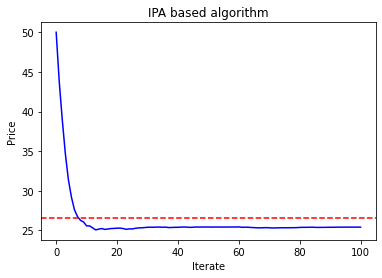

In [9]:
## Plots

optimal_price = 26.6

plt.plot(price_iterates, color = "blue")
plt.axhline(optimal_price, color = "red", linestyle="dashed")

plt.xlabel("Iterate")
plt.ylabel("Price")
plt.title("IPA based algorithm")

In [10]:
lambda_iterates = [model_vars_iterates[i][0] for i in range(n_iters+1)]
theta_1_iterates = [model_vars_iterates[i][1] for i in range(n_iters+1)]
theta_2_iterates = [model_vars_iterates[i][2] for i in range(n_iters+1)]

Text(0.5, 1.0, 'IPA based algorithm')

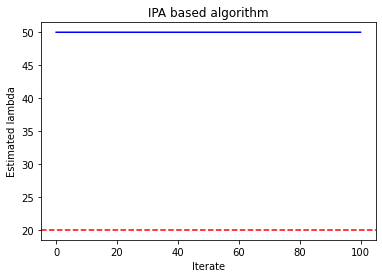

In [11]:
# Lambda plots

plt.plot(lambda_iterates, color = "blue")
plt.axhline(true_model_vars[0], color = "red", linestyle="dashed")

plt.xlabel("Iterate")
plt.ylabel("Estimated lambda")
plt.title("IPA based algorithm")

Text(0.5, 1.0, 'IPA based algorithm')

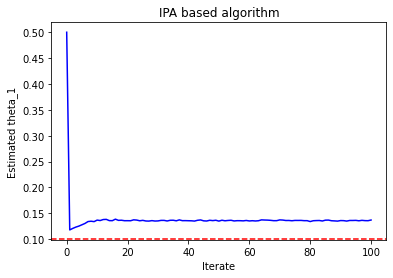

In [12]:
# theta_1 plots

plt.plot(theta_1_iterates, color = "blue")
plt.axhline(true_model_vars[1], color = "red", linestyle="dashed")

plt.xlabel("Iterate")
plt.ylabel("Estimated theta_1")
plt.title("IPA based algorithm")

Text(0.5, 1.0, 'IPA based algorithm')

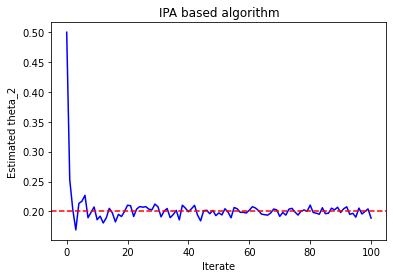

In [13]:
# theta_2 plots

plt.plot(theta_2_iterates, color = "blue")
plt.axhline(true_model_vars[2], color = "red", linestyle="dashed")

plt.xlabel("Iterate")
plt.ylabel("Estimated theta_2")
plt.title("IPA based algorithm")